In [355]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import statsmodels.api as sm
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, accuracy_score,  r2_score

In [300]:
def create_graph(game_data, week_num):
    G = nx.DiGraph()
    margin_totals = defaultdict(float)
    game_counts = defaultdict(int)
    
    # Iterate over each game result
    for _, row in game_data.iterrows():
        winner = row['winner']
        loser = row['loser']
        week = row['week']
        margin = row['margin']

        key = (loser, winner)
        margin_totals[key] += margin
        game_counts[key] += 1

    # Add edges with average margin as weight
    for (loser, winner), total_margin in margin_totals.items():
        avg_margin = total_margin / game_counts[(loser, winner)]
        G.add_edge(loser, winner, weight=avg_margin)
    
    return G

In [301]:
# Function to calculate rankings based on the weighted graph
def calculate_rankings(graph):
    # Calculate PageRank with weights
    return pd.DataFrame(nx.pagerank(graph, weight='weight').items(), columns=['Team', 'Ranking'])

In [396]:
# Assume 'game_results' is your complete dataset of NFL game results
df_results = pd.read_csv('../data/nfl_games_pfr.csv')

In [399]:
# Offensive rankings
# Initialize an empty list to store rankings DataFrames
ranking_dfs = []

df_played = df_results[~df_results['Margin Yds'].isna()]

game_results = df_played[['season','week','Winner Yds','Loser Yds','Margin Yds']]

game_results = game_results.rename(columns={'Winner Yds':'winner', 'Loser Yds':'loser','Margin Yds':'margin'})

# Loop over each distinct season in the dataset
for season in game_results['season'].unique():
    # Filter the game data for the current season
    season_data = game_results[game_results['season'] == season]
    
    # Loop over the weeks for this season
    for week in range(2, season_data['week'].max() + 1):
        # Filter the game data up to the current week for the current season
        filtered_data = season_data[season_data['week'] <= week]
        
        # Create the directed graph for the current season and weeks
        G = create_graph(filtered_data,week)
        
        # Calculate the rankings based on the weighted graph
        rankings = calculate_rankings(G)

        # Round the rankings to 4 decimal places
        rankings['Ranking'] = rankings['Ranking'].round(5)
        
        # Add columns indicating the season and week, with a leading zero for weeks
        rankings['SeasonWeek'] = f"{season}_W{str(week).zfill(2)}"
        rankings['Season'] = season
        rankings['Week'] = week
        rankings['Type'] = "Offense"
        
        # Append the rankings to the list
        ranking_dfs.append(rankings)

# Concatenate all rankings DataFrames into a single DataFrame
final_offense_rankings_df = pd.concat(ranking_dfs)

# Display the cross-tab DataFrame
print(final_offense_rankings_df.head())


    season  week Winner Yds Loser Yds  Margin Yds
0     2024     5        ATL        TB       217.0
14    2024     1        BAL        KC        99.0
15    2024     1         GB       PHI         4.0
16    2024     1        PIT       ATL        44.0
17    2024     1        HOU       IND       114.0
  Team  Ranking SeasonWeek  Season  Week     Type
0   KC  0.01464   2024_W02    2024     2  Offense
1  BAL  0.03461   2024_W02    2024     2  Offense
2  PHI  0.01464   2024_W02    2024     2  Offense
3   GB  0.02024   2024_W02    2024     2  Offense
4  ATL  0.02501   2024_W02    2024     2  Offense


In [400]:
# Defensive rankings
# Initialize an empty list to store rankings DataFrames
ranking_dfs = []

df_played = df_results[~df_results['Margin Yds'].isna()]

game_results = df_played[['season','week','Winner TO','Loser TO','Margin TO']]
game_results = game_results.rename(columns={'Winner TO':'winner', 'Loser TO':'loser','Margin TO':'margin'})

# Loop over each distinct season in the dataset
for season in game_results['season'].unique():
    # Filter the game data for the current season
    season_data = game_results[game_results['season'] == season]
    
    # Loop over the weeks for this season
    for week in range(2, season_data['week'].max() + 1):
        # Filter the game data up to the current week for the current season
        filtered_data = season_data[season_data['week'] <= week]
        
        # Create the directed graph for the current season and weeks
        G = create_graph(filtered_data,week)
        
        # Calculate the rankings based on the weighted graph
        rankings = calculate_rankings(G)

        # Round the rankings to 4 decimal places
        rankings['Ranking'] = rankings['Ranking'].round(5)
        
        # Add columns indicating the season and week, with a leading zero for weeks
        rankings['SeasonWeek'] = f"{season}_W{str(week).zfill(2)}"
        rankings['Season'] = season
        rankings['Week'] = week
        rankings['Type'] = "Defense"
        
        # Append the rankings to the list
        ranking_dfs.append(rankings)

# Concatenate all rankings DataFrames into a single DataFrame
final_defense_rankings_df = pd.concat(ranking_dfs)

# Display the cross-tab DataFrame
print(final_defense_rankings_df.head())



  Team  Ranking SeasonWeek  Season  Week     Type
0  BAL  0.01919   2024_W02    2024     2  Defense
1   KC  0.04936   2024_W02    2024     2  Defense
2   GB  0.01919   2024_W02    2024     2  Defense
3  PHI  0.05197   2024_W02    2024     2  Defense
4  PIT  0.01919   2024_W02    2024     2  Defense


In [401]:
# Total Score rankings
# Initialize an empty list to store rankings DataFrames
ranking_dfs = []

df_played = df_results[~df_results['Margin Yds'].isna()]

game_results = (
    df_played[['season','week','Winner Abbr','Loser Abbr','home_team_winner']]
    .rename(columns={'Winner Abbr':'winner', 'Loser Abbr':'loser'})
)
game_results['margin'] = game_results['home_team_winner'].apply(lambda x: 1 if x else 5)

# Loop over each distinct season in the dataset
for season in game_results['season'].unique():
    # Filter the game data for the current season
    season_data = game_results[game_results['season'] == season]
    
    # Loop over the weeks for this season
    for week in range(2, season_data['week'].max() + 1):
        # Filter the game data up to the current week for the current season
        filtered_data = season_data[season_data['week'] <= week]
        
        # Create the directed graph for the current season and weeks
        G = create_graph(filtered_data,week)
        
        # Calculate the rankings based on the weighted graph
        rankings = calculate_rankings(G)

        # Round the rankings to 4 decimal places
        rankings['Ranking'] = rankings['Ranking'].round(5)
        
        # Add columns indicating the season and week, with a leading zero for weeks
        rankings['SeasonWeek'] = f"{season}_W{str(week).zfill(2)}"
        rankings['Season'] = season
        rankings['Week'] = week
        rankings['Type'] = "Score"
        
        # Append the rankings to the list
        ranking_dfs.append(rankings)

# Concatenate all rankings DataFrames into a single DataFrame
final_score_rankings_df = pd.concat(ranking_dfs)

# Display the cross-tab DataFrame
print(final_score_rankings_df.head())

  Team  Ranking SeasonWeek  Season  Week   Type
0  BAL  0.01670   2024_W02    2024     2  Score
1   KC  0.02143   2024_W02    2024     2  Score
2   GB  0.01907   2024_W02    2024     2  Score
3  PHI  0.03291   2024_W02    2024     2  Score
4  ATL  0.04467   2024_W02    2024     2  Score


In [402]:
combined_rankings = pd.concat([final_offense_rankings_df,final_defense_rankings_df,final_score_rankings_df])
print(combined_rankings)


   Team  Ranking SeasonWeek  Season  Week     Type
0    KC  0.01464   2024_W02    2024     2  Offense
1   BAL  0.03461   2024_W02    2024     2  Offense
2   PHI  0.01464   2024_W02    2024     2  Offense
3    GB  0.02024   2024_W02    2024     2  Offense
4   ATL  0.02501   2024_W02    2024     2  Offense
..  ...      ...        ...     ...   ...      ...
27  DAL  0.02177   2015_W17    2015    17    Score
28  PHI  0.03799   2015_W17    2015    17    Score
29  ATL  0.05473   2015_W17    2015    17    Score
30  MIN  0.04472   2015_W17    2015    17    Score
31   SF  0.01801   2015_W17    2015    17    Score

[14496 rows x 6 columns]


In [307]:
# Output the results and pivot table to a CSV file
# pivot_df.to_csv('../data/nfl_rankings_pivot.csv')
combined_rankings.to_csv('../data/nfl_rankings_combined.csv')

In [404]:
# Preprocess the combined_rankings dataframe to create offensive and defensive rank features
rankings = combined_rankings.pivot(index=['Team', 'SeasonWeek', 'Season', 'Week'], columns='Type', values='Ranking').reset_index()
rankings.rename(columns={'Offense': 'OffenseRank', 'Defense': 'DefenseRank', 'Score': 'ScoreRank'}, inplace=True)

# Adjust rankings to use the prior week's data
rankings['Week'] = rankings['Week'] + 1

# Merge the rankings with game results to create the feature set
merged_df = df_results.merge(rankings, left_on=['Home Team', 'season', 'week'], right_on=['Team', 'Season', 'Week'], how='left')
merged_df.rename(columns={'OffenseRank': 'Home_OffenseRank', 'DefenseRank': 'Home_DefenseRank', 'ScoreRank': 'Home_ScoreRank'}, inplace=True)

merged_df = merged_df.merge(rankings, left_on=['Away Team', 'season', 'week'], right_on=['Team', 'Season', 'Week'], how='left')
merged_df.rename(columns={'OffenseRank': 'Away_OffenseRank', 'DefenseRank': 'Away_DefenseRank', 'ScoreRank': 'Away_ScoreRank'}, inplace=True)

# Drop unnecessary columns
merged_df.drop(columns=['Unnamed: 0','Team_x', 'Season_x','SeasonWeek_x', 'Week_x', 'Team_y', 'Season_y', 'SeasonWeek_y', 'Week_y'], inplace=True)

# Filter to only games where rankings exist for both teams
merged_df = merged_df.dropna(subset=['Home_OffenseRank', 'Home_DefenseRank', 'Away_OffenseRank', 'Away_DefenseRank'])

# Create target variable (spread)
merged_df['Spread'] = merged_df.apply(lambda row: row['PtsW'] - row['PtsL'] if row['Home Team'] == row['Winner Abbr'] else row['PtsL'] - row['PtsW'], axis=1)

# Create feature Deltas
merged_df['Delta_OffenseRank'] = merged_df['Home_OffenseRank'] - merged_df['Away_OffenseRank']
merged_df['Delta_DefenseRank'] = merged_df['Home_DefenseRank'] - merged_df['Away_DefenseRank']
merged_df['Delta_ScoreRank'] = merged_df['Home_ScoreRank'] - merged_df['Away_ScoreRank']
merged_df['Ratio_ScoreRank'] = merged_df['Home_ScoreRank'] / (merged_df['Away_ScoreRank'] + 1e-5)
merged_df['Ratio_OffenseRank'] = merged_df['Home_OffenseRank'] / (merged_df['Away_OffenseRank'] + 1e-5)
merged_df['Ratio_DefenseRank'] = merged_df['Home_DefenseRank'] / (merged_df['Away_DefenseRank'] + 1e-5)
merged_df['intTerm1'] = merged_df['Home_OffenseRank'] * merged_df['Away_DefenseRank']
merged_df['intTerm2'] = merged_df['Away_OffenseRank'] * merged_df['Home_DefenseRank']
merged_df['intTerm3'] = merged_df['Home_OffenseRank'] * merged_df['Away_OffenseRank']
merged_df['intTerm4'] = merged_df['Away_DefenseRank'] * merged_df['Home_DefenseRank']
merged_df['intTerm5'] = merged_df['Home_OffenseRank'] / (merged_df['Away_DefenseRank'] + 1e-5)
merged_df['intTerm6'] = merged_df['Home_DefenseRank'] / (merged_df['Away_OffenseRank'] + 1e-5)
merged_df['quadTerm1'] = merged_df['Home_OffenseRank'] * merged_df['Home_OffenseRank']
merged_df['quadTerm2'] = merged_df['Away_OffenseRank'] * merged_df['Away_OffenseRank']
merged_df['quadTerm3'] = merged_df['Home_DefenseRank'] * merged_df['Home_DefenseRank']
merged_df['quadTerm4'] = merged_df['Away_DefenseRank'] * merged_df['Away_DefenseRank']

merged_df['HomeStrength'] = merged_df['Home_OffenseRank'] + merged_df['Home_DefenseRank']+ merged_df['Home_ScoreRank']
merged_df['AwayStrength'] = merged_df['Away_OffenseRank'] + merged_df['Away_DefenseRank']+ merged_df['Away_ScoreRank']

print(merged_df.columns)




Index(['Day', 'Date', 'Time', 'Winner', 'LoserIsHome', 'Loser', 'PtsW', 'PtsL',
       'YdsW', 'TOW', 'YdsL', 'TOL', 'season', 'week', 'Winner Abbr',
       'Loser Abbr', 'Home Team', 'Away Team', 'Winner Yds', 'Loser Yds',
       'Margin Yds', 'Winner TO', 'Loser TO', 'Margin TO', 'home_team_winner',
       'Home_DefenseRank', 'Home_OffenseRank', 'Home_ScoreRank', 'Week',
       'Away_DefenseRank', 'Away_OffenseRank', 'Away_ScoreRank', 'Spread',
       'Delta_OffenseRank', 'Delta_DefenseRank', 'Delta_ScoreRank',
       'Ratio_ScoreRank', 'Ratio_OffenseRank', 'Ratio_DefenseRank', 'intTerm1',
       'intTerm2', 'intTerm3', 'intTerm4', 'intTerm5', 'intTerm6', 'quadTerm1',
       'quadTerm2', 'quadTerm3', 'quadTerm4', 'HomeStrength', 'AwayStrength'],
      dtype='object')


Mean Squared Error: 195.03498778114158
Winner Prediction Accuracy: 63.33%
Winner Prediction Accuracy for |Delta_ScoreRank| >= 0 (n=231): 66.23%
Winner Prediction Accuracy for |Delta_ScoreRank| >= 0.01 (n=153): 73.86%
Winner Prediction Accuracy for |Delta_ScoreRank| >= 0.02 (n=99): 74.75%
Winner Prediction Accuracy for |Delta_ScoreRank| >= 0.03 (n=58): 75.86%
Winner Prediction Accuracy for |Delta_ScoreRank| >= 0.04 (n=30): 76.67%
Winner Prediction Accuracy for |Delta_ScoreRank| >= 0.05 (n=17): 82.35%
Winner Prediction Accuracy for |Delta_ScoreRank| <= 0 (n=197): 58.88%
Winner Prediction Accuracy for |Delta_ScoreRank| <= -0.01 (n=124): 58.87%
Winner Prediction Accuracy for |Delta_ScoreRank| <= -0.02 (n=82): 60.98%
Winner Prediction Accuracy for |Delta_ScoreRank| <= -0.03 (n=53): 64.15%
Winner Prediction Accuracy for |Delta_ScoreRank| <= -0.04 (n=32): 59.38%
Winner Prediction Accuracy for |Delta_ScoreRank| <= -0.05 (n=18): 61.11%


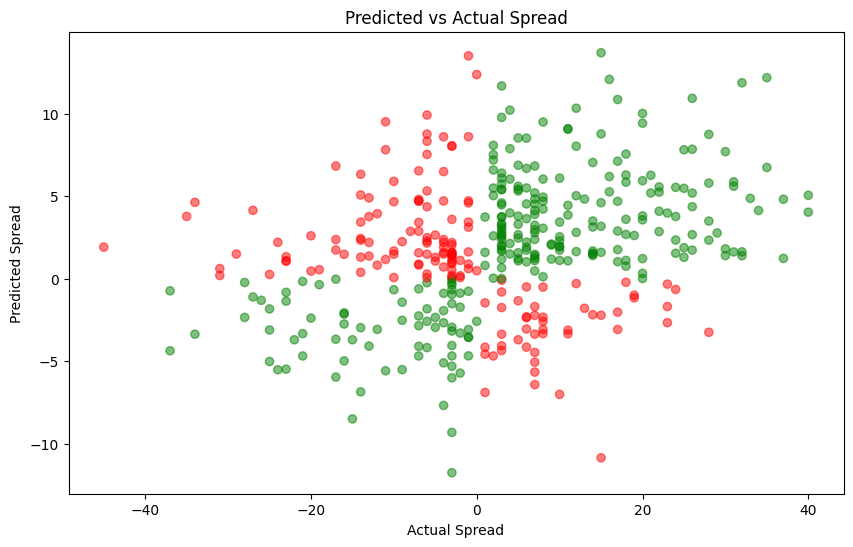

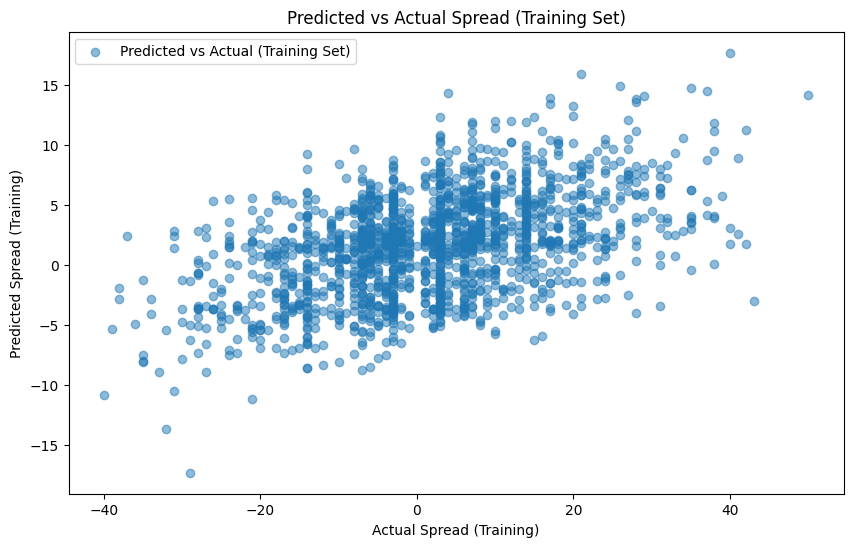

   Home Team Away Team  Delta_ScoreRank  Predicted Spread
1        MIN       NYJ          0.08177          9.428990
2        HOU       BUF          0.05753          7.522282
3        CHI       CAR         -0.01591         -0.225073
4        WAS       CLE          0.00890          4.776725
5        JAC       IND         -0.07130         -2.727572
6         NE       MIA          0.00670          2.403185
7        CIN       BAL         -0.00838         -3.014478
8         SF       ARI          0.00018          1.954525
9        DEN        LV          0.04603          4.561688
10       LAR        GB         -0.01063         -4.904443
11       SEA       NYG          0.01612          6.237938
12       PIT       DAL          0.05876          6.058064
13        KC        NO          0.02441          4.187999


C:\Users\see_w\AppData\Local\Temp\ipykernel_19840\3234919604.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_upcoming['Predicted Spread'] = y_pred_new


In [415]:
merged_played = merged_df[~merged_df['Margin Yds'].isna()]
merged_upcoming = merged_df[merged_df['Margin Yds'].isna()]

# Define features and target
X = merged_played[['Delta_ScoreRank','intTerm1','intTerm3', 'intTerm4']]
X = merged_played[['Delta_ScoreRank','Delta_OffenseRank','Ratio_ScoreRank','intTerm1', 'intTerm2','intTerm3', 'intTerm4']]
y = merged_played['Spread']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_new = merged_upcoming[['Delta_ScoreRank','Delta_OffenseRank','Ratio_ScoreRank','intTerm1', 'intTerm2','intTerm3', 'intTerm4']]

# Train the linear regression model
#model = LinearRegression()
#model = Ridge(alpha=0.1)  # You can tune the alpha parameter
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)
#model = RandomForestRegressor(n_estimators=50, max_depth=3, random_state=42)
#model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
#model = KNeighborsRegressor(n_neighbors=5)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
# Calculate accuracy of predicting the winner
y_pred_winner = ['Home' if pred > 0 else 'Away' for pred in y_pred]
y_test_winner = ['Home' if actual > 0 else 'Away' for actual in y_test]
accuracy = accuracy_score(y_test_winner, y_pred_winner)
print(f"Winner Prediction Accuracy: {accuracy * 100:.2f}%")


# Calculate accuracy at different setpoints for absolute Delta_OffenseRank
setpoints = [0,0.01,0.02,0.03,0.04,0.05]
for setpoint in setpoints:
    subset_idx = X_test['Delta_ScoreRank'] >= setpoint
    subset_X_test = X_test[subset_idx]
    subset_y_test = y_test[subset_idx]
    subset_y_pred = model.predict(subset_X_test)
    subset_y_pred_winner = ['Home' if pred > 0 else 'Away' for pred in subset_y_pred]
    subset_y_test_winner = ['Home' if actual > 0 else 'Away' for actual in subset_y_test]
    subset_accuracy = accuracy_score(subset_y_test_winner, subset_y_pred_winner)
    print(f"Winner Prediction Accuracy for |Delta_ScoreRank| >= {setpoint} (n={len(subset_y_test)}): {subset_accuracy * 100:.2f}%")

setpoints = [0,-0.01,-0.02,-0.03,-0.04,-.05]
for setpoint in setpoints:
    subset_idx = X_test['Delta_ScoreRank'] <= setpoint
    subset_X_test = X_test[subset_idx]
    subset_y_test = y_test[subset_idx]
    subset_y_pred = model.predict(subset_X_test)
    subset_y_pred_winner = ['Home' if pred > 0 else 'Away' for pred in subset_y_pred]
    subset_y_test_winner = ['Home' if actual > 0 else 'Away' for actual in subset_y_test]
    subset_accuracy = accuracy_score(subset_y_test_winner, subset_y_pred_winner)
    print(f"Winner Prediction Accuracy for |Delta_ScoreRank| <= {setpoint} (n={len(subset_y_test)}): {subset_accuracy * 100:.2f}%")

'''
# Model coefficients
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
print(coefficients)
print('Intercept:', model.intercept_)
'''

# Plot predictions vs actuals
plt.figure(figsize=(10, 6))
colors = ['green' if y_pred == y_actual else 'red' for y_pred, y_actual in zip(y_pred_winner, y_test_winner)]
plt.scatter(y_test, y_pred, alpha=0.5, c=colors)
plt.xlabel('Actual Spread')
plt.ylabel('Predicted Spread')
plt.title('Predicted vs Actual Spread')
#plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')
plt.show()

# Plot predictions vs actuals for training set
y_train_pred = model.predict(X_train)
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_train_pred, alpha=0.5, label='Predicted vs Actual (Training Set)')
plt.xlabel('Actual Spread (Training)')
plt.ylabel('Predicted Spread (Training)')
plt.title('Predicted vs Actual Spread (Training Set)')
#plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--', label='Ideal Fit')
plt.legend()
plt.show()

model.fit(X, y)

# Make predictions on the test set
y_pred_new = model.predict(X_new)
merged_upcoming['Predicted Spread'] = y_pred_new
print(merged_upcoming[['Home Team','Away Team','Delta_ScoreRank','Predicted Spread']])

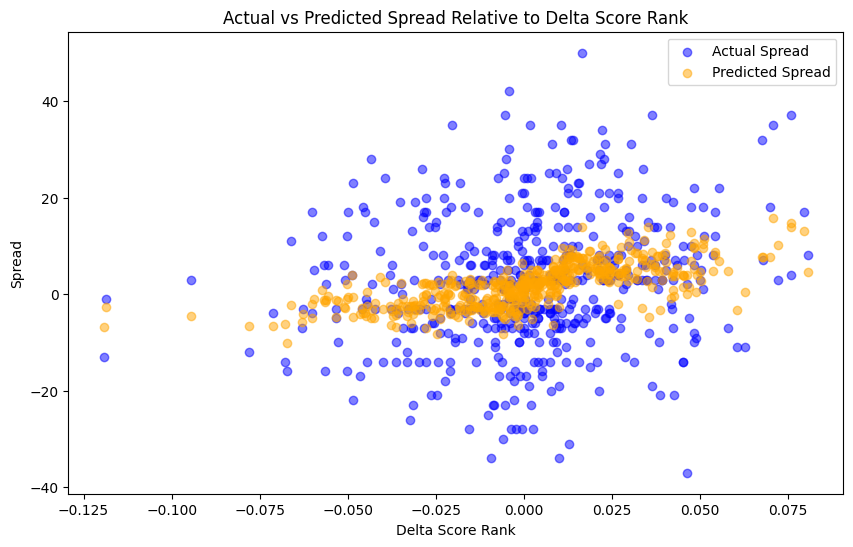

In [422]:
filtered_latest = merged_played[merged_played['season'] >= 2022]
filtered_X = filtered_latest[['Delta_ScoreRank','Delta_OffenseRank','Ratio_ScoreRank','intTerm1', 'intTerm2','intTerm3', 'intTerm4']]

# Plot actuals and predictions for labeled data relative to Delta_OffenseRank
plt.figure(figsize=(10, 6))
plt.scatter(filtered_latest['Delta_ScoreRank'], filtered_latest['Spread'], alpha=0.5, label='Actual Spread', color='blue')
plt.scatter(filtered_latest['Delta_ScoreRank'], model.predict(filtered_X), alpha=0.5, label='Predicted Spread', color='orange')
plt.xlabel('Delta Score Rank')
plt.ylabel('Spread')
plt.title('Actual vs Predicted Spread Relative to Delta Score Rank')
plt.legend()
plt.show()

In [390]:
# Define features and target
X1 = merged_played[['Home_ScoreRank','Away_ScoreRank']]
X2 = merged_played[['Delta_ScoreRank']]
X3 = merged_played[['Home_OffenseRank', 'Home_DefenseRank','Away_OffenseRank', 'Away_DefenseRank']]
X4 = merged_played[['Delta_OffenseRank','Delta_DefenseRank']]
X5 = merged_played[['Home_OffenseRank', 'Home_DefenseRank','Home_ScoreRank', 'Away_OffenseRank', 'Away_DefenseRank','Away_ScoreRank']]
X6 = merged_played[['Delta_ScoreRank','Delta_OffenseRank','Delta_DefenseRank']]
X7 = merged_played[['Delta_ScoreRank','Delta_OffenseRank']]

X8 = merged_played[['Home_OffenseRank', 'Home_DefenseRank','Home_ScoreRank', 'Away_OffenseRank',\
               'Away_DefenseRank','Away_ScoreRank', 'Delta_ScoreRank','Delta_OffenseRank',\
                'Delta_DefenseRank', 'Ratio_ScoreRank', 'Ratio_OffenseRank', 'Ratio_DefenseRank',\
                'intTerm1', 'intTerm2','intTerm3', 'intTerm4', \
                'intTerm5', 'intTerm6', 'quadTerm1','quadTerm2', 'quadTerm3', 'quadTerm4', \
                'HomeStrength', 'AwayStrength']]

X9 = merged_played[['Delta_ScoreRank','intTerm1','intTerm3', 'intTerm4']]
X10 = merged_played[['Ratio_ScoreRank']]
X11 = merged_played[['Ratio_ScoreRank','Ratio_OffenseRank','Ratio_DefenseRank']]
X12 = merged_played[['Delta_ScoreRank','Delta_OffenseRank','Delta_DefenseRank','Ratio_ScoreRank','Ratio_OffenseRank','Ratio_DefenseRank']]
X13 = merged_played[['Delta_ScoreRank','Delta_OffenseRank','Ratio_ScoreRank','intTerm1', 'intTerm2','intTerm3', 'intTerm4']]
X14 = merged_played[['Ratio_ScoreRank','intTerm1','intTerm3', 'intTerm4']]
X15 = merged_played[['Home_OffenseRank', 'Home_DefenseRank','Delta_ScoreRank','Delta_OffenseRank','AwayStrength']]
X16 = merged_played[['Delta_ScoreRank', 'Ratio_ScoreRank','intTerm1','intTerm3']]
X17 = merged_played[['Delta_ScoreRank','Delta_OffenseRank','Ratio_ScoreRank', 'Ratio_OffenseRank', 'Ratio_DefenseRank']]

# Put feature sets in a list
X_list = [X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17]

y = merged_played['Spread']


In [387]:
X_list = [X8]# Iterate over each feature set and fit the model using statsmodels
for i, X in enumerate(X_list, start=1):
    #model = LinearRegression()
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42, eval_metric='rmse')
    selector = RFE(model, n_features_to_select=5)  # Select the top 5 features
    selector.fit(X, y)
    print(selector.support_)  # True for selected features


[False False False False False False  True  True False  True  True  True
 False False False False False False False False False False False False]


In [374]:

# Iterate over each feature set and fit the model using statsmodels
for i, X in enumerate(X_list, start=1):
    # Add constant to X for statsmodels
    X = sm.add_constant(X)
    
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train the linear regression model using statsmodels to see p-values
    model = sm.OLS(y_train, X_train).fit()
    print(f"\nModel {i} Summary:\n")
    print(model.summary())



Model 1 Summary:

                            OLS Regression Results                            
Dep. Variable:                 Spread   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     36.87
Date:                Sat, 05 Oct 2024   Prob (F-statistic):           2.14e-16
Time:                        15:12:24   Log-Likelihood:                -6782.3
No. Observations:                1677   AIC:                         1.357e+04
Df Residuals:                    1674   BIC:                         1.359e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.2172

In [391]:
for i, X in enumerate(X_list, start=1):    
    # Initialize and fit the XGBoost regressor

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42, eval_metric='rmse')
    #model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    
    # Print fit summary (MSE and R-squared as an example)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Mean Squared Error for dataframe {i}: {mse}")
    print(f"Rsquared for dataframe {i+1}: {r2}")


    



Mean Squared Error for dataframe 1: 200.79686467717553
Rsquared for dataframe 2: 0.06807065010070801
Mean Squared Error for dataframe 2: 201.44105998421867
Rsquared for dataframe 3: 0.06508070230484009
Mean Squared Error for dataframe 3: 207.25899583068653
Rsquared for dataframe 4: 0.03807878494262695
Mean Squared Error for dataframe 4: 205.3016473977521
Rsquared for dataframe 5: 0.04716324806213379
Mean Squared Error for dataframe 5: 196.70143360674064
Rsquared for dataframe 6: 0.08707809448242188
Mean Squared Error for dataframe 6: 197.91259410771423
Rsquared for dataframe 7: 0.08145701885223389
Mean Squared Error for dataframe 7: 201.3214379946097
Rsquared for dataframe 8: 0.06563597917556763
Mean Squared Error for dataframe 8: 196.33245411779018
Rsquared for dataframe 9: 0.08879059553146362
Mean Squared Error for dataframe 9: 195.84829572710254
Rsquared for dataframe 10: 0.09103769063949585
Mean Squared Error for dataframe 10: 200.15645451815445
Rsquared for dataframe 11: 0.0710428